In [1]:
import numpy as np
from Bio import AlignIO
import os
import subprocess

In [21]:
def find_nearest(pdb, n_nearest):
    import numpy as np
    from scipy.spatial import distance
    """
    This function finds the n_nearest atoms to a given atom in a pdb file.
    """
    with open(pdb, 'r') as f:
        lines = [line for line in f if line.startswith('ATOM') and line[13:15] == 'CA']
    coords = np.array([line.split()[6:9] for line in lines], dtype=float)
    distance_matrix = distance.cdist(coords, coords)
    nearest_ind = np.array([np.argsort(distance_matrix[i])[1:n_nearest+1] for i in range(len(distance_matrix))])
    nearest_dist = np.array([np.sort(distance_matrix[i])[1:n_nearest+1] for i in range(len(distance_matrix))])
    return nearest_ind, nearest_dist

In [23]:
def jsd(p, q):
    """
    This function calculates the Jensen-Shannon divergence between two probability distributions.
    """
    from scipy.special import rel_entr
    import numpy as np
    m = 0.5 * (p + q)
    jsd = 0.5 * np.sum(rel_entr(p, m)) + 0.5 * np.sum(rel_entr(q, m))
    return jsd

In [105]:
def fasta2dict(fasta_path):
    with open(fasta_path) as f:
        content = f.read()
        entries = content.split('>')[1:]
        names = [entry.split('\n')[0] for entry in entries]
        seqs = [entry.split('\n')[1:] for entry in entries]
        seqs = [''.join(seq) for seq in seqs]
        dic = dict(zip(names,seqs))
        return dic

In [8]:
def sum_fasta(seqs:str, headings:str, path:str, other_seq = None, other_heading = None):
    import os
    if len(seqs) != len(headings):
        raise ValueError('Sequence and heading list not of same length')
    content = ''
    if other_seq != None and other_heading != None:
        content += '>'+other_heading+'\n'+other_seq+'\n'
    for n in range(len(seqs)):
        content+='>'+headings[n]+'\n'
        content+=seqs[n]+'\n'
    with open(path,'w') as f:
        f.write(content)
    return content

In [1]:
def mmseqs_cons23(input_fasta : str, database_db : str, input_pdb : str = None, windows:bool = False, max_seqs:int = 1000, include_neighbors:bool=False, n_nearest:int=5, decay:float=0.5, alpha:float=0.5, output_path = './data/out_alignment23.fasta'):
    import subprocess
    import numpy as np
    import os
    if not os.path.exists('./data/mmseqs_data'):
        os.makedirs('./data/mmseqs_data')
    subprocess.run(["mmseqs","createdb", input_fasta, "./data/mmseqs_data/protein_db23"])   
    subprocess.run(["mmseqs","search","./data/mmseqs_data/protein_db23","./data/mmseqs_data/database_db23","./data/mmseqs_data/result23","./data/mmseqs_data/tmp","--max-seqs",str(max_seqs)])
    subprocess.run(["mmseqs","result2msa","./data/mmseqs_data/protein_db23","./data/mmseqs_data/database_db23","./data/mmseqs_data/result23","./data/mmseqs_data/alignment_msa23.fasta","--msa-format-mode", "2"])     # generate multiple sequence alignment from search result
    with open(input_fasta) as f:
        text = f.read().split('>')[1]
        nameinterest = text.split('\n')[0]
        seqinterest = ''.join(text.split('\n')[1:])
    with open('./data/mmseqs_data/alignment_msa23.fasta_header.ffdata','rb') as f:
        text = f.read()
        text = text.decode('utf-8').replace('\x00', '\t')
        prots = text.split('\t')
    prots = [x.split('|')[0] if '|taxID' in x else x for x in prots]
    with open('./data/mmseqs_data/alignment_msa23.fasta_sequence.ffdata', 'rb') as f:
        text2 = f.read()
        text2 = text2.decode('utf-8').replace('\x00', '\t')
    seqs = text2.split('\t')
    protseq = dict(zip(prots, seqs))
    with open('./data/mmseqs_data/alignment23.m8') as f:
        content = f.readlines()
        alis = [content[x].split('\t')[1].split('|')[0] for x in range(len(content)) if '|' in content[x].split('\t')[1].split('|')]
    alseqs = [protseq[al].strip() for al in alis]
    sum_fasta(alseqs, alis, './data/tobealigned23.fasta', seqinterest, nameinterest)
    subprocess.run(['muscle','-align','./data/tobealigned23.fasta','-output','./data/firstalignment23.fasta'])
    alignmentdict = fasta2dict('./data/firstalignment23.fasta')
    arr = np.array(list(''.join(test[nameinterest])))
    inds = np.where(arr != '-')[0]
    cleaned = [''.join(np.array(list(seq))[inds]) for seq in list(alignmentdict.values())]
    sum_fasta(cleaned, list(temp.keys()), path = output_path)

In [2]:
def mmseqs_cons2(input_fasta : str, database_db : str, input_pdb : str = None,windows:bool = False, max_seqs:int = 1000, include_neighbors:bool=False, n_nearest:int=5, decay:float=0.5, alpha:float=0.5, output_path = './data/mmseqs_data/alignment_msa.fasta'):
    import subprocess
    import numpy as np
    import os
    from Bio import AlignIO
    if not os.path.exists('./data/mmseqs_data'):
        os.makedirs('./data/mmseqs_data')
    subprocess.run(["mmseqs","createdb", input_fasta, "./data/mmseqs_data/protein_db"])   
    subprocess.run(["mmseqs","search","./data/mmseqs_data/protein_db","./data/mmseqs_data/database_db","./data/mmseqs_data/result","./data/mmseqs_data/tmp","--max-seqs",str(max_seqs)])
    subprocess.run(["mmseqs","result2msa","./data/mmseqs_data/protein_db","./data/mmseqs_data/database_db","./data/mmseqs_data/result",output_path,"--msa-format-mode", "2"])     # generate multiple sequence alignment from search result
    with open(output_path, "rb+") as file:     # remove NUL character in fasta
        file.seek(-1, 2)       # move pointer to last byte and go back one more
        file.truncate()
        
    aa_order = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    blosum62_background = np.array([0.078, 0.051, 0.041, 0.052, 0.024, 0.034, 0.059, 0.083, 0.025, 0.062, 0.092, 0.056, 0.024, 0.044, 0.043, 0.059, 0.055, 0.014, 0.034, 0.072])
    alignment = AlignIO.read('./data/mmseqs_data/alignment_msa.fasta', 'fasta')   # read msa using biopython
    alignment_array = np.array([list(rec.seq) for rec in alignment], dtype = 'U1')
    aa_prop_array = np.zeros((20, alignment_array.shape[1]))   # initiate array to store amino acid proportions
    for n_col, col in enumerate(alignment_array.T):            # calculate amino acid proportions for each column
        col_no_gaps = np.char.upper(col[col != '-'])
        aa_percs = np.array([np.sum(col_no_gaps == aa)/len(col_no_gaps) for aa in aa_order])    
        aa_prop_array[:, n_col] = aa_percs                              
    conservation_scores = np.zeros(len(alignment_array.T))
    for n_col, col in enumerate(aa_prop_array.T):
        conservation_scores[n_col] = jsd(col, blosum62_background)  # compute Jensen-Shannon divergence for each column
    if include_neighbors:
        ind,dist = find_nearest(input_pdb, n_nearest)
        weights = np.array([np.exp(-decay*row) for row in dist])
        weightsums = np.sum(weights, axis = 1)
        neighbors = conservation_scores[ind]
        neighbors_weighted = np.sum(neighbors*weights, axis = 1)/weightsums
        conservation_scores_neighbors = alpha * conservation_scores + (1-alpha) * neighbors_weighted
        return conservation_scores, conservation_scores_neighbors
    else:
        return conservation_scores

In [35]:
tes = AlignIO.read('./data/mmseqs_data/alignment_msa.fasta','fasta')
arr = np.array([list(rec.seq) for rec in tes], dtype = 'U1')
len(arr.T)

363

In [2]:
from mmseq import mmseqs_cons
temp = mmseqs_cons('./data/Q72KT1.fasta','./data/850db.fasta')

./data/mmseqs_data/protein_db exists and will be overwritten
createdb ./data/Q72KT1.fasta ./data/mmseqs_data/protein_db 

MMseqs Version:       	13.45111
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[
Time for merging to protein_db_h: 0h 0m 0s 8ms
Time for merging to protein_db: 0h 0m 0s 7ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 31ms
./data/mmseqs_data/result exists and will be overwritten
search ./data/mmseqs_data/protein_db ./data/mmseqs_data/database_db ./data/mmseqs_data/result ./data/mmseqs_data/tmp --max-seqs 1000 

MMseqs Version:                        	13.45111
Substitution matrix                    	nucl:nucleotide.out,aa:blosum62.out
Add backtrace                          	false
Alignment mode                         	2
Alignment mode                         	0
Allow wrapped scoring                  	false

In [9]:
temp[:10]

array([0.63694105, 0.52011183, 0.55386659, 0.46478871, 0.50182057,
       0.51919405, 0.51076311, 0.60423363, 0.48755964, 0.46478871])

In [3]:
temp_spatial = mmseqs_cons('./data/Q72KT1.fasta','./data/850db.fasta',input_pdb = './data/Q72KT1.pdb', include_neighbors = True)

./data/mmseqs_data/protein_db exists and will be overwritten
createdb ./data/Q72KT1.fasta ./data/mmseqs_data/protein_db 

MMseqs Version:       	13.45111
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[
Time for merging to protein_db_h: 0h 0m 0s 7ms
Time for merging to protein_db: 0h 0m 0s 7ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 30ms
./data/mmseqs_data/result exists and will be overwritten
search ./data/mmseqs_data/protein_db ./data/mmseqs_data/database_db ./data/mmseqs_data/result ./data/mmseqs_data/tmp --max-seqs 1000 

MMseqs Version:                        	13.45111
Substitution matrix                    	nucl:nucleotide.out,aa:blosum62.out
Add backtrace                          	false
Alignment mode                         	2
Alignment mode                         	0
Allow wrapped scoring                  	false

In [4]:
temp_kl = mmseqs_cons('./data/Q72KT1.fasta','./data/850db.fasta',input_pdb = './data/Q72KT1.pdb', include_neighbors = True,method = 'rel_entr')

./data/mmseqs_data/protein_db exists and will be overwritten
createdb ./data/Q72KT1.fasta ./data/mmseqs_data/protein_db 

MMseqs Version:       	13.45111
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[
Time for merging to protein_db_h: 0h 0m 0s 7ms
Time for merging to protein_db: 0h 0m 0s 6ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 29ms
./data/mmseqs_data/result exists and will be overwritten
search ./data/mmseqs_data/protein_db ./data/mmseqs_data/database_db ./data/mmseqs_data/result ./data/mmseqs_data/tmp --max-seqs 1000 

MMseqs Version:                        	13.45111
Substitution matrix                    	nucl:nucleotide.out,aa:blosum62.out
Add backtrace                          	false
Alignment mode                         	2
Alignment mode                         	0
Allow wrapped scoring                  	false

In [12]:
print(temp_spatial[0][:20])
print(temp_spatial[1][:20])

[0.63694105 0.52011183 0.55386659 0.46478871 0.50182057 0.51919405
 0.51076311 0.60423363 0.48755964 0.46478871 0.60423363 0.51465157
 0.60264483 0.60264483 0.54737388 0.55386659 0.59181465 0.53603192
 0.53603192 0.54737388]
[0.55075051 0.51314026 0.49505482 0.47397989 0.48494774 0.50340174
 0.52548613 0.55294998 0.51769536 0.51068712 0.56218254 0.53805671
 0.55677799 0.59077585 0.55561545 0.53554546 0.53509779 0.54712757
 0.54810723 0.55763258]


In [9]:
print(np.where(temp_spatial[0] > np.quantile(temp_spatial[0],0.8)))
print(temp_kl[0][temp_kl[0] > np.quantile(temp_kl[0],0.8)])

(array([  0,   1,   2,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  27,  29,
        30,  35,  37,  53,  54,  56,  75,  79,  80,  81,  84, 107, 110,
       118, 156, 169, 189, 191, 193, 196, 207, 268, 284, 290, 311, 320,
       326, 336, 337, 338, 339, 340, 341, 343, 344, 346, 348, 353, 354,
       355, 356, 357, 358, 359, 360, 361, 362]),)
[3.72970145 2.27706477 2.55104645 2.17413028 2.24467686 2.22397419
 3.14655516 3.14655516 2.20992656 3.12356565 3.12356565 2.48891467
 2.55104645 2.97592965 2.3859667  2.3859667  2.48891467 2.88240359
 2.97592965 3.12356565 3.14655516 2.97592965 2.16316353 2.3859667
 2.3859667  2.55245246 2.93853774 3.14655516 3.621513   2.8605287
 2.33840306 2.71374243 2.48891467 3.50056237 2.7019396  2.25024087
 3.60314697 3.38719106 3.44911055 2.59805565 2.47947541 2.21116288
 2.24021247 2.48891467 2.48891467 2.19591926 2.33122113 2.3266575
 2.32345579 2.48891467 2.30042925 2.18232284 2.37690917 

In [2]:
from mmseq import calc_conservation
cons = calc_conservation('../bn300-wog/alignments/Cre_recombinase_msa.fasta',method = 'jsd',input_pdb = '../bn300-wog/pdbs/cre_recombinase.pdb',include_neighbors = False)

In [29]:
rounded = [round(x,2) for x in cons]

In [6]:
len('MSNLLTVHQNLPALPVDATSDEVRKNLMDMFRDRQAFSEHTWKMLLSVCRSWAAWCKLNNRKWFPAEPEDVRDYLLYLQARGLAVKTIQQHLGQLNMLHRRSGLPRPSDSNAVSLVMRRIRKENVDAGERAKQALAFERTDFDQVRSLMENSDRCQDIRNLAFLGIAYNTLLRIAEIARIRVKDISRTDGGRMLIHIGRTKTLVSTAGVEKALSLGVTKLVERWISVSGVADDPNNYLFCRVRKNGVAAPSATSQLSTRALEGIFEATHRLIYGAKDDSGQRYLAWSGHSARVGAARDMARAGVSIPEIMQAGGWTNVNIVMNYIRNLDSETGAMVRLLEDGD')

343

In [3]:
for x,y in enumerate(cons):
    if y < 0.2:
        print(x,y)

15 0.1686524701163285
16 0.14669351145369747
17 0.13869815794218024
18 0.1482335767874735
19 0.1932277735062958
23 0.15538643079717948
24 0.19921075046058734
27 0.15248447655642206
30 0.19211682475657268
34 0.19884393906023212
45 0.15565139025094415
50 0.1150705366141791
52 0.08012056600384584
53 0.1351547673536046
56 0.1042316644558335
57 0.12803274267966014
58 0.1781548333247261
60 0.19120599716754177
61 0.08185142695794706
66 0.16238926207350415
68 0.16208136362326386
71 0.19956442310212913
72 0.1739194411775192
75 0.07769886126257566
76 0.1650762633066103
78 0.1437289128536248
79 0.1348355902889636
80 0.12110752308178137
82 0.1504793988814978
84 0.17696998918035228
88 0.17945811949323742
91 0.17462970099070474
96 0.15960736668491798
100 0.14442961565630197
101 0.18753959247127244
104 0.18339243499388425
108 0.07499042417231416
110 0.1521824711377771
111 0.07478674638502539
113 0.1532347694915185
114 0.16722022019746946
115 0.15442707133337666
122 0.11602396338789328
123 0.178074492

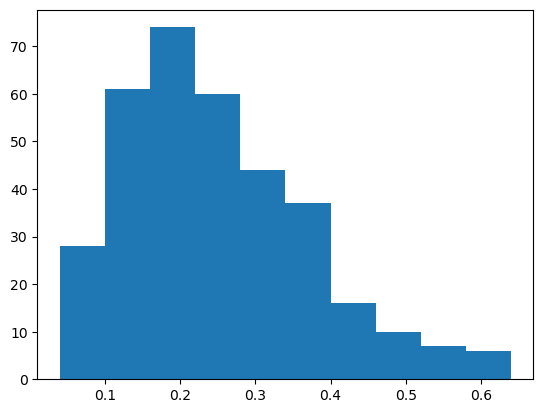

In [30]:
import matplotlib.pyplot as plt
plt.hist(rounded)
plt.show()
